<a href="https://colab.research.google.com/github/sanjivyash/ML-Codes/blob/master/Style-Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Image Style Transfer
This project is an implementation of the idea presented in [Image Style Transfer Using ConvNets](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) presented by Gatys, Ecker and Bethge. Even though this implementation is completely original, the idea behind the project has been heavily inspired by this paper. 

In [0]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [0]:
import torch
import torchvision
from torchvision import models, transforms
from torch import nn, optim
import torch.nn.functional as F

### Use GPU if available

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Running on the GPU')
    gpu_flag = True
else:
    device = torch.device('cpu')
    print('Running on the CPU')
    gpu_flag = False 

Running on the GPU


In [0]:
vgg = models.vgg19(pretrained = True).features.eval()
layers = list(vgg.children())

In [5]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
for parameters in vgg.parameters():
    parameters.requires_grad = False

# Helper Functions 

These include three important functions: 

*   **set_images()** : This function finds the style and content images for you in the contents of the colab file you're currently running.
*   **normalise()** : This function normalises any image and will be used to normalise the content and style images before training.
*   **display_image()** : Takes a normalised image, its mean and standard deviation. Then it rescales the image appropriately to plot it.







In [0]:
def set_images(base, flair):
    img_size = 512 if gpu_flag else 128

    content = cv.imread(f'/content/{base}')
    content = cv.cvtColor(content, cv.COLOR_BGR2RGB)
    content = cv.resize(content, (img_size, img_size))
    

    style = cv.imread(f'/content/{flair}')
    style = cv.cvtColor(style, cv.COLOR_BGR2RGB)
    style = cv.resize(style, (img_size, img_size))
  
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,6))
    ax1.imshow(content)
    ax2.imshow(style)
    plt.show()

    return content, style


def normalise(image):
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
    ])

    img = image.copy()
    img = transform(img)[:3,:,:].unsqueeze(0)
    img = img.to(device)
    
    return img


def display_image(image):

    img = image.to('cpu').detach().numpy().copy()
    img = np.array(img, dtype=np.float64).squeeze().transpose(1,2,0)

    img = img * np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
    img = img.clip(0,1)

    plt.figure(figsize = (10,6))
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

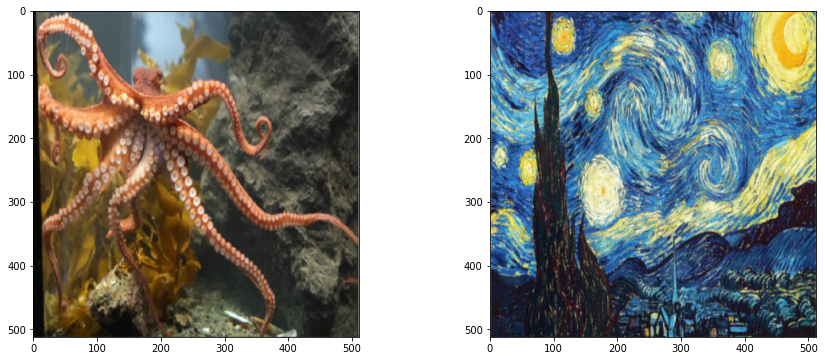

In [8]:
base = 'octo.png'
flair = 'art.png'
content, style = set_images(base, flair)
content, style = normalise(content), normalise(style)

# Custom Class
This custom class helps us extract features from the VGG model when we pass an image through it.

In [0]:
# 0,5,10,19,21,28 layers have to be accounted for
class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.part1 = nn.Sequential(*layers[:1])
        self.part2 = nn.Sequential(*layers[1:6])
        self.part3 = nn.Sequential(*layers[6:11])
        self.part4 = nn.Sequential(*layers[11:20])
        self.part5 = nn.Sequential(*layers[20:22])
        self.part6 = nn.Sequential(*layers[22:29])
    
   
    def forward(self, x):
        style = []

        x = self.part1(x)
        style.append(x)

        x = self.part2(x)
        style.append(x)

        x = self.part3(x)
        style.append(x)

        x = self.part4(x)
        style.append(x)

        x = self.part5(x)
        content = x  # for content comparison

        x = self.part6(x)
        style.append(x)

        return content, style


net = Net()
net.to(device)

for parameters in net.parameters():
    parameters.requires_grad = False

fig = content.clone().to(device)
fig.requires_grad = True

optimiser = optim.Adam([fig], 1e-3)

In [0]:
tar_content, _ = net(content)
_, tar_style = net(style)
style_weights = [1, 0.8, 0.35, 0.25, 0.2]  # experimental weights

# Helper Functions


*   **content_loss() :** This function helps us compares the content image and our trained image 
*   **style_loss() :** This function helps us compare the style image and our trained image
*   **gram_matrix() :** The evaluation of style is done on the basis of [Gramian Matrix](https://en.wikipedia.org/wiki/Gramian_matrix). This function helps us in calculating these values.





In [0]:
def content_loss(value):

    loss = tar_content - value
    loss = torch.mean(loss**2)
    return loss


def gram_matrix(mat):

    matrix = mat.view(mat.shape[1], -1)
    gram_mat = matrix @ matrix.t()
    return gram_mat


def style_loss(values):
    loss = 0

    for i in range(len(values)):
        b, d, h, w = values[i].shape
        diff = gram_style[i] - gram_matrix(values[i])
        loss += style_weights[i] * torch.mean(diff ** 2)

    return loss

### Gram Matrix for Style Image

In [0]:
gram_style = []

for style in tar_style:
    gram_style.append(gram_matrix(style))

# Training our Figure

In [0]:
# weight_ratio determines the weight given to style_loss

def fit(model, optimiser, weight_ratio = 1e6, epochs = 1000):
    model.eval()
    images = []

    for epoch in tqdm(range(epochs)):
        fig_content, fig_style = model(fig)
        loss = content_loss(fig_content)
        loss += weight_ratio * style_loss(fig_style)

        model.zero_grad()
        loss.backward()
        optimiser.step()

        if(epoch % 200 == 0):
            images.append(fig)
            display_image(fig)
    
    return images

In [0]:
images = fit(net, optimiser)

# Comparing Trained and Original Image

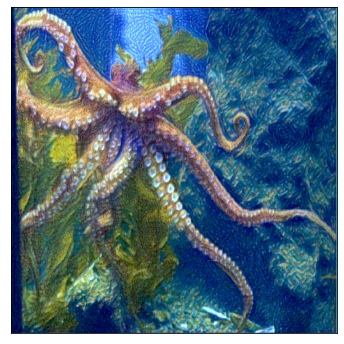

In [16]:
trained_image = images[-1]
display_image(images[-1])

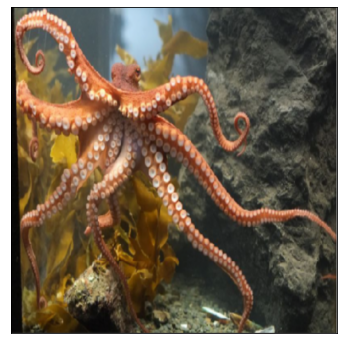

In [17]:
display_image(content)

# Saving our Image
Please use the helper function below to save the stylized image 

In [0]:
def save_image(image):

    img = image.to('cpu').detach().numpy().copy()
    img = np.array(img, dtype=np.float64).squeeze().transpose(1,2,0)

    img = img * np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
    img = img.clip(0,1)

    plt.imsave(f'stylish-{base}', img)

In [0]:
save_image(trained_image)